# ResNet on Stanford Cars

## Imports

In [3]:
%%capture
!pip install pytorch-ignite
!pip install fvcore
!pip install lightning
!pip install torchmetrics
!pip install torchinfo
!pip install finetuning_scheduler

In [4]:
import numpy as np
import math
from collections import defaultdict
import matplotlib.pyplot as plt
import math
import seaborn as sns
import argparse
import tqdm
import csv

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim.adamw import AdamW
import torchvision
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import _LRScheduler
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
import lightning as pl
from lightning.pytorch import LightningModule
import finetuning_scheduler as fts
import torchmetrics
from torchinfo import summary

import ignite.metrics
import ignite.contrib.handlers
from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.utils import convert_tensor

from fvcore.nn import FlopCountAnalysis, ActivationCountAnalysis, flop_count_table

from PIL import ImageFilter, ImageOps, Image
import random

import warnings
warnings.filterwarnings("ignore")

log_dir = "/kaggle/working"
pl.seed_everything(42)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
INFO: Seed set to 42


42

In [5]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

## Parser

In [6]:
def get_args_parser():
    parser = argparse.ArgumentParser('ResNet for Stanford Cars', add_help=False)
    parser.add_argument('--num_classes', type=int, default=196, choices=[10, 100, 1000],
                    help='Dataset name')

    # Model parameters
    parser.add_argument('--image_size', default=224, type=int, help=""" Size of input image. """)

    # Training/Optimization parameters
    parser.add_argument('--weight_decay', type=float, default=1e-1, help="""Initial value of the
        weight decay. With ViT, a smaller value at the beginning of training works well.""")
    parser.add_argument('--batch_size', default=128, type=int,
        help='Per-GPU batch-size : number of distinct images loaded on one GPU.')
    parser.add_argument('--epochs', default=200, type=int, help='Number of epochs of training.')
    parser.add_argument("--lr", default=0.001, type=float, help="""Learning rate at the end of
        linear warmup (highest LR used during training). The learning rate is linearly scaled
        with the batch size, and specified here for a reference batch size of 256.""")
    parser.add_argument("--warmup_epochs", default=10, type=int,
        help="Number of epochs for the linear learning-rate warm up.")
    parser.add_argument('--min_lr', type=float, default=1e-6, help="""Target LR at the
        end of optimization. We use a cosine LR schedule with linear warmup.""")
    parser.add_argument('--optimizer', default='adamw', type=str,
        choices=['adamw', 'sgd', 'lars'], help="""Type of optimizer. Recommend using adamw with ViTs.""")
    
    return parser

args, unknown = get_args_parser().parse_known_args()

In [7]:
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("device:", DEVICE)

device: cuda


In [8]:
import os
print(os.listdir("../input/stanford-car-dataset-by-classes-folder"))

['names.csv', 'car_data', 'anno_test.csv', 'anno_train.csv']


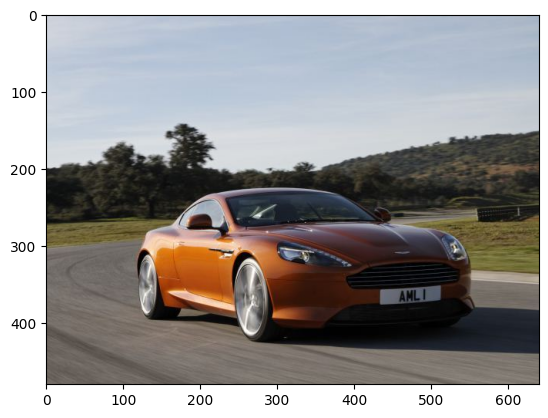

In [9]:
path_base = '../input/stanford-car-dataset-by-classes-folder'

image = Image.open(path_base + '/car_data/car_data/train/Aston Martin Virage Coupe 2012/00206.jpg')
imgplot = plt.imshow(image)
plt.show()

In [10]:
class_names = []

with open(path_base + '/names.csv') as csvDataFile:
    csvReader = csv.reader(csvDataFile, delimiter=';')
    for row in csvReader:
        class_names.append(row[0])

In [11]:
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

In [12]:
train_transform = transforms.Compose([
    transforms.TrivialAugmentWide(interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop(224),
    transforms.PILToTensor(),
    transforms.ConvertImageDtype(torch.float),
    transforms.RandomErasing(p=0.1),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [13]:
train_data_dir = path_base + '/car_data/car_data/train'
test_data_dir = path_base + '/car_data/car_data/test'

train_dset = datasets.ImageFolder(train_data_dir, transform=train_transform)
val_dset = datasets.ImageFolder(train_data_dir, transform=test_transform)
test_dset = datasets.ImageFolder(test_data_dir, transform=test_transform)

val_count = round(len(train_dset) * 0.2)
train_count = len(train_dset) - val_count

train_dset, _ = torch.utils.data.random_split(train_dset, [train_count, val_count])
_, val_dset = torch.utils.data.random_split(val_dset, [train_count, val_count])

train_loader = torch.utils.data.DataLoader(train_dset, batch_size=args.batch_size, shuffle=True, pin_memory=True, 
                                           num_workers=args.num_workers)
val_loader = torch.utils.data.DataLoader(val_dset, batch_size=args.batch_size, shuffle=True, pin_memory=True, 
                                           num_workers=args.num_workers)
test_loader = torch.utils.data.DataLoader(test_dset, batch_size=args.batch_size, shuffle=False, pin_memory=True,
                                         num_workers=args.num_workers)

print(f"Data loaded: there are {len(train_dset)} images in the training data.")
print(f"Data loaded: there are {len(val_dset)} images in the validation data.")
print(f"Data loaded: there are {len(test_dset)} images in the testing data.")

Data loaded: there are 6515 images in the training data.
Data loaded: there are 1629 images in the validation data.
Data loaded: there are 8041 images in the testing data.


In [14]:
dataiter = iter(train_loader)
images, labels = next(dataiter)
print("Type of images:", type(images))
print("Type of the first element in images:", type(images[0]))
print("Shape of the first image:", images[0].shape if isinstance(images[0], torch.Tensor) else "Not a tensor")

Type of images: <class 'torch.Tensor'>
Type of the first element in images: <class 'torch.Tensor'>
Shape of the first image: torch.Size([3, 224, 224])


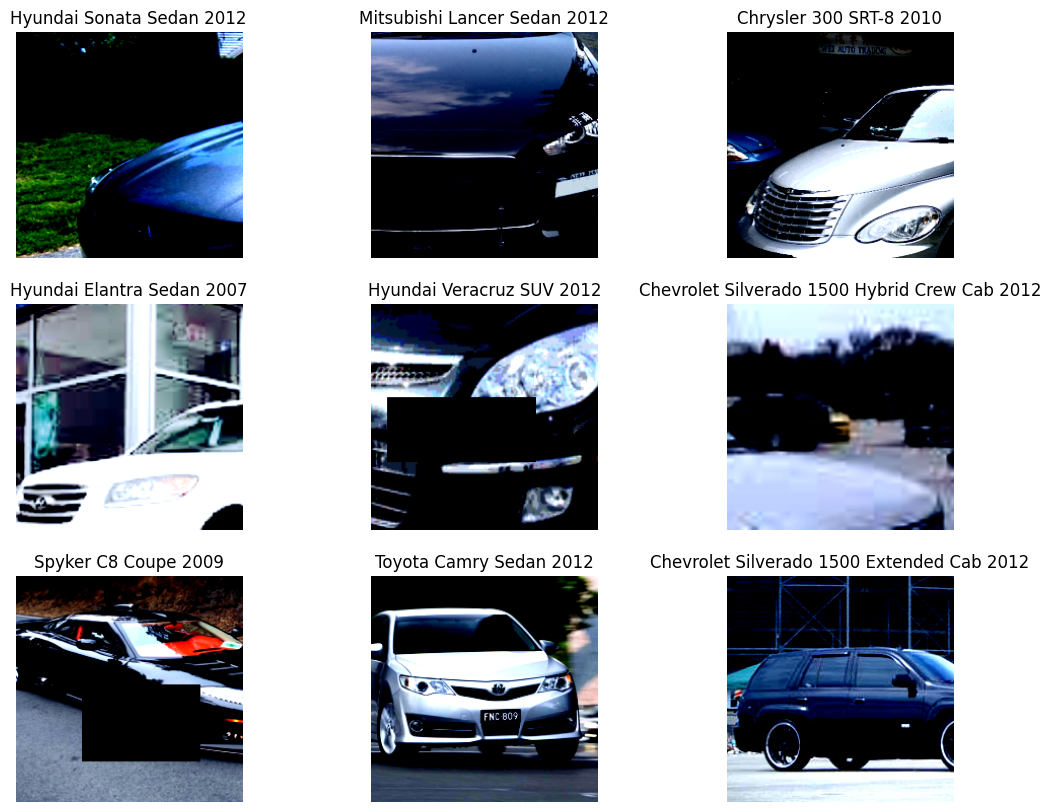

In [15]:
mean = torch.tensor([0.4707, 0.4602, 0.4550])
std = torch.tensor([0.2638, 0.2629, 0.2678])

def matplotlib_imshow(img, mean, std):
    img = img * mean + std 
    plt.imshow(img.numpy())

images, labels = next(iter(train_loader))
plt.figure(figsize=(13,10))

for i in range(9):
    image = images[i]
    image = image.permute(1,2,0)
    plt.subplot(3,3,i+1)
    matplotlib_imshow(image, mean, std)
    plt.title(f"{class_names[labels[i]]}")
    plt.axis('off')

## Lightning Module

In [17]:
from typing import Tuple

def separate_weight_decayable_params(params):
    wd_params, no_wd_params = [], []

    for param in params:
        param_list = no_wd_params if param.ndim < 2 else wd_params
        param_list.append(param)

    return wd_params, no_wd_params

def get_adam_optimizer(
    params,
    lr: float = 1e-4,
    wd: float = 1e-2,
    betas: Tuple[int, int] = (0.9, 0.99),
    eps: float = 1e-8,
    filter_by_requires_grad = False,
    omit_gammas_and_betas_from_wd = True,
    **kwargs
):
    has_weight_decay = wd > 0.

    if filter_by_requires_grad:
        params = [t for t in params if t.requires_grad]

    opt_kwargs = dict(
        lr = lr,
        betas = betas,
        eps = eps
    )

    if not has_weight_decay:
        return Adam(params, **opt_kwargs)

    opt_kwargs = {'weight_decay': wd, **opt_kwargs}

    if not omit_gammas_and_betas_from_wd:
        return AdamW(params, **opt_kwargs)

    wd_params, no_wd_params = separate_weight_decayable_params(params)

    params = [
        {'params': wd_params},
        {'params': no_wd_params, 'weight_decay': 0},
    ]

    return AdamW(params, **opt_kwargs)

In [18]:
class CosineAnnealingWarmupRestarts(_LRScheduler):
    """
        optimizer (Optimizer): Wrapped optimizer.
        first_cycle_steps (int): First cycle step size.
        cycle_mult(float): Cycle steps magnification. Default: -1.
        max_lr(float): First cycle's max learning rate. Default: 0.1.
        min_lr(float): Min learning rate. Default: 0.001.
        warmup_steps(int): Linear warmup step size. Default: 0.
        gamma(float): Decrease rate of max learning rate by cycle. Default: 1.
        last_epoch (int): The index of last epoch. Default: -1.
    """

    def __init__(self,
                 optimizer : torch.optim.Optimizer,
                 first_cycle_steps : int,
                 cycle_mult : float = 1.,
                 max_lr : float = 0.1,
                 min_lr : float = 0.001,
                 warmup_steps : int = 0,
                 gamma : float = 1.,
                 last_epoch : int = -1
        ):
        assert warmup_steps < first_cycle_steps

        self.first_cycle_steps = first_cycle_steps # first cycle step size
        self.cycle_mult = cycle_mult # cycle steps magnification
        self.base_max_lr = max_lr # first max learning rate
        self.max_lr = max_lr # max learning rate in the current cycle
        self.min_lr = min_lr # min learning rate
        self.warmup_steps = warmup_steps # warmup step size
        self.gamma = gamma # decrease rate of max learning rate by cycle

        self.cur_cycle_steps = first_cycle_steps # first cycle step size
        self.cycle = 0 # cycle count
        self.step_in_cycle = last_epoch # step size of the current cycle

        super(CosineAnnealingWarmupRestarts, self).__init__(optimizer, last_epoch)

        # set learning rate min_lr
        self.init_lr()

    def init_lr(self):
        self.base_lrs = []
        for param_group in self.optimizer.param_groups:
            param_group['lr'] = self.min_lr
            self.base_lrs.append(self.min_lr)

    def get_lr(self):
        if self.step_in_cycle == -1:
            return self.base_lrs
        elif self.step_in_cycle < self.warmup_steps:
            return [(self.max_lr - base_lr)*self.step_in_cycle / self.warmup_steps + base_lr for base_lr in self.base_lrs]
        else:
            return [base_lr + (self.max_lr - base_lr) \
                    * (1 + math.cos(math.pi * (self.step_in_cycle-self.warmup_steps) \
                                    / (self.cur_cycle_steps - self.warmup_steps))) / 2
                    for base_lr in self.base_lrs]

    def step(self, epoch=None):
        if epoch is None:
            epoch = self.last_epoch + 1
            self.step_in_cycle = self.step_in_cycle + 1
            if self.step_in_cycle >= self.cur_cycle_steps:
                self.cycle += 1
                self.step_in_cycle = self.step_in_cycle - self.cur_cycle_steps
                self.cur_cycle_steps = int((self.cur_cycle_steps - self.warmup_steps) * self.cycle_mult) + self.warmup_steps
        else:
            if epoch >= self.first_cycle_steps:
                if self.cycle_mult == 1.:
                    self.step_in_cycle = epoch % self.first_cycle_steps
                    self.cycle = epoch // self.first_cycle_steps
                else:
                    n = int(math.log((epoch / self.first_cycle_steps * (self.cycle_mult - 1) + 1), self.cycle_mult))
                    self.cycle = n
                    self.step_in_cycle = epoch - int(self.first_cycle_steps * (self.cycle_mult ** n - 1) / (self.cycle_mult - 1))
                    self.cur_cycle_steps = self.first_cycle_steps * self.cycle_mult ** (n)
            else:
                self.cur_cycle_steps = self.first_cycle_steps
                self.step_in_cycle = epoch

        self.max_lr = self.base_max_lr * (self.gamma**self.cycle)
        self.last_epoch = math.floor(epoch)
        for param_group, lr in zip(self.optimizer.param_groups, self.get_lr()):
            param_group['lr'] = lr

In [43]:
class StanfordCarsNet(pl.LightningModule):
    def __init__(self, lr=1e-2, min_lr=1e-6, weight_decay=1e-4, is_finetuned = False):
        super().__init__()
        self.save_hyperparameters()
        self.learning_rate = lr
        self.min_lr = min_lr
        self.weight_decay = weight_decay
        self.is_finetuned = is_finetuned
        
        backbone = torchvision.models.resnet50(pretrained=True)
        layers = list(backbone.children())[:-1]
        self.feature_extractor = nn.Sequential(*layers)
        num_features = backbone.fc.in_features
        num_target_classes = 196
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(num_features, num_target_classes)    
        )
        
        self.train_acc = torchmetrics.Accuracy(task="multiclass",
                                               num_classes=num_target_classes)
        self.val_acc = torchmetrics.Accuracy(task="multiclass",
                                             num_classes=num_target_classes)
        self.test_acc = torchmetrics.Accuracy(task="multiclass",
                                             num_classes=num_target_classes)
        
    @property
    def finetuningscheduler_callback(self) -> fts.FinetuningScheduler:
        fts_callback = [c for c in self.trainer.callbacks if isinstance(c, fts.FinetuningScheduler)]
        return fts_callback[0] if fts_callback else None
        
    def forward(self, x):
        if self.is_finetuned:
            representations = self.feature_extractor(x).flatten(1)
        else:
            self.feature_extractor.eval()
            with torch.no_grad():
                representations = self.feature_extractor(x).flatten(1)
        
        logits = self.classifier(representations)
        return logits
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        self.train_acc(logits, y)

        tensorboard_logs = {"train_loss":loss, "train_acc": self.train_acc}
        self.log_dict(tensorboard_logs, on_step=False, on_epoch=True)
        return loss
    
    def on_train_epoch_end(self):
        if self.finetuningscheduler_callback:
            self.log("finetuning_schedule_depth", float(self.finetuningscheduler_callback.curr_depth))
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        self.val_acc(logits, y)

        tensorboard_logs = {"val_loss":loss, "val_acc":self.val_acc}
        self.log_dict(tensorboard_logs, prog_bar=True, on_step=False, on_epoch=True)
        return loss
    
    def predict_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        preds = torch.argmax(logits, dim=1)
        return preds
    
    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=self.learning_rate, weight_decay = self.weight_decay)
        scheduler = {
            "scheduler": CosineAnnealingWarmRestarts(optimizer, 20, 1, 1e-6),
            "interval": "epoch",
        }
        return [optimizer], [scheduler]
    
    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        self.test_acc(logits, y)
        self.log('test_acc', self.test_acc, on_step=False, on_epoch=True)

In [44]:
model = StanfordCarsNet(is_finetuned = False)

summary(model, (1, 3, 224, 224), depth=3,
            verbose=0,
            col_width=16,
            col_names=["kernel_size", "output_size", "num_params"])

Layer (type:depth-idx)                        Kernel Shape     Output Shape     Param #
StanfordCarsNet                               --               [1, 196]         --
├─Sequential: 1-1                             --               [1, 2048, 1, 1]  --
│    └─Conv2d: 2-1                            [7, 7]           [1, 64, 112, 112] 9,408
│    └─BatchNorm2d: 2-2                       --               [1, 64, 112, 112] 128
│    └─ReLU: 2-3                              --               [1, 64, 112, 112] --
│    └─MaxPool2d: 2-4                         3                [1, 64, 56, 56]  --
│    └─Sequential: 2-5                        --               [1, 256, 56, 56] --
│    │    └─Bottleneck: 3-1                   --               [1, 256, 56, 56] 75,008
│    │    └─Bottleneck: 3-2                   --               [1, 256, 56, 56] 70,400
│    │    └─Bottleneck: 3-3                   --               [1, 256, 56, 56] 70,400
│    └─Sequential: 2-6                        --               

In [45]:
if __name__ == "__main__":
    model = StanfordCarsNet(is_finetuned = False).to(device)
    model.eval()
    inputs = torch.randn(1, 3, 224, 224).to(device)
    model(inputs)

    flops = FlopCountAnalysis(model, inputs)
    param = sum(p.numel() for p in model.parameters() if p.requires_grad)
    acts = ActivationCountAnalysis(model, inputs)

    print(f"total flops : {flops.total()}")
    print(f"total activations: {acts.total()}")
    print(f"number of parameter: {param}")

    print(flop_count_table(flops, max_depth=1))

total flops : 4109865984
total activations: 11114180
number of parameter: 23909636
| module             | #parameters or shape   | #flops   |
|:-------------------|:-----------------------|:---------|
| model              | 23.91M                 | 4.11G    |
|  feature_extractor |  23.508M               |  4.109G  |
|  classifier.1      |  0.402M                |  0.401M  |


In [46]:
dev_trainer = pl.Trainer(fast_dev_run=True, accelerator="gpu")
dev_trainer.fit(model, train_loader, val_loader)

INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO: Running in `fast_dev_run` mode: will run the requested loop using 1 batch(es). Logging and checkpointing is suppressed.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name              | Type               | Params
---------------------------------------------------------
0 | feature_extractor | Sequential         | 23.5 M
1 | classifier        | Sequential         | 401 K 
2 | train_acc         | MulticlassAccuracy | 0     
3 | val_acc           | MulticlassAccuracy | 0     
4 | test_acc          | MulticlassAccuracy | 0     
---------------------------------------------------------
23.9 M    Trainable params
0         Non-trainable params
23.9 M    Total params
95.639    Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_steps=1` reached.


INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO: LR finder stopped early after 93 steps due to diverging loss.
INFO: Learning rate set to 0.003311311214825908
INFO: Restoring states from the checkpoint path at /kaggle/working/.lr_find_f034458e-d9e3-4c17-a23c-0d4ff75b4a61.ckpt
INFO: Restored all states from the checkpoint at /kaggle/working/.lr_find_f034458e-d9e3-4c17-a23c-0d4ff75b4a61.ckpt


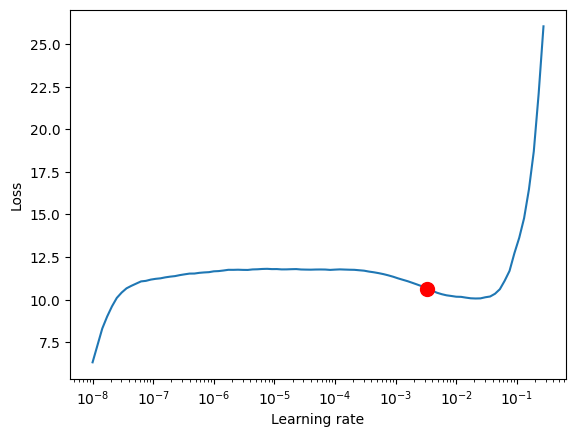

In [47]:
from lightning.pytorch.tuner import Tuner

trainer = pl.Trainer()
tuner = Tuner(trainer)
lr_finder = tuner.lr_find(model, train_loader, val_loader)

new_lr = lr_finder.suggestion()
model.hparams.lr = new_lr

fig = lr_finder.plot(suggest=True)
fig.show()

In [48]:
print(new_lr)

0.003311311214825908


In [49]:
from lightning.pytorch.callbacks import Callback
from lightning.pytorch.callbacks import ModelCheckpoint, LearningRateMonitor

class MetricTracker(Callback):
    
    def __init__(self):
        self.val_loss = []
        self.val_acc = []
        self.train_loss = []
        self.train_acc = []
        self.lr = []

    def on_validation_epoch_end(self, trainer, module):
        val_loss = trainer.logged_metrics['val_loss'].item()
        val_acc = trainer.logged_metrics['val_acc'].item()
        self.val_loss.append(val_loss)
        self.val_acc.append(val_acc)
        
    def on_train_epoch_end(self, trainer, module):
        train_loss = trainer.logged_metrics['train_loss'].item()
        train_acc = trainer.logged_metrics['train_acc'].item()
        lr = module.optimizers().param_groups[0]['lr']
        self.train_loss.append(train_loss)
        self.train_acc.append(train_acc)
        self.lr.append(lr)

metric_tracker = MetricTracker()
checkpoint_callback = ModelCheckpoint(monitor='val_loss')
lr_monitor = LearningRateMonitor(logging_interval='epoch')

In [50]:
epochs = 100
lr = new_lr
weight_decay=1e-4


model = StanfordCarsNet(lr=lr, weight_decay=weight_decay, is_finetuned = False)

trainer = pl.Trainer(max_epochs=epochs,
                     accelerator='gpu',
                     default_root_dir = os.path.join(log_dir, "phase1"),
                     callbacks=[metric_tracker, checkpoint_callback, lr_monitor])

trainer.fit(model=model,
            train_dataloaders = train_loader,
            val_dataloaders = val_loader)

INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name              | Type               | Params
---------------------------------------------------------
0 | feature_extractor | Sequential         | 23.5 M
1 | classifier        | Sequential         | 401 K 
2 | train_acc         | MulticlassAccuracy | 0     
3 | val_acc           | MulticlassAccuracy | 0     
4 | test_acc          | MulticlassAccuracy | 0     
---------------------------------------------------------
23.9 M    Trainable params
0         Non-trainable params
23.9 M    Total params
95.639    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=100` reached.


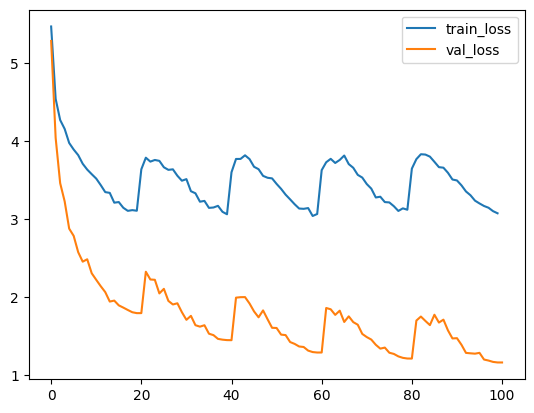

In [51]:
sns.lineplot(x=range(len(metric_tracker.train_loss)), y=metric_tracker.train_loss, label="train_loss")
sns.lineplot(x=range(len(metric_tracker.val_loss)), y=metric_tracker.val_loss, label="val_loss")
plt.legend()
plt.show()

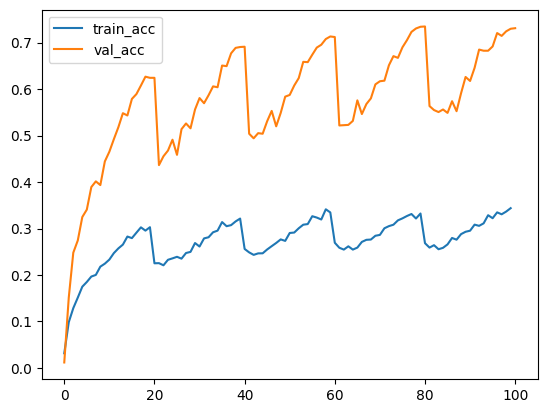

In [52]:
sns.lineplot(x=range(len(metric_tracker.train_acc)), y=metric_tracker.train_acc, label="train_acc")
sns.lineplot(x=range(len(metric_tracker.val_acc)), y=metric_tracker.val_acc, label="val_acc")
plt.legend()
plt.show()

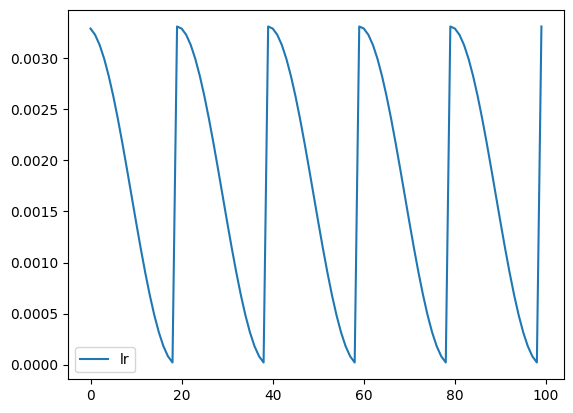

In [53]:
sns.lineplot(x=range(len(metric_tracker.lr)), y=metric_tracker.lr, label="lr")
plt.legend()
plt.show()

In [54]:
print("Best model path: " + checkpoint_callback.best_model_path)
trainer.test(model, test_loader)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Best model path: /kaggle/working/phase1/lightning_logs/version_1/checkpoints/epoch=99-step=5100.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.49061062932014465    │
└───────────────────────────┴───────────────────────────┘

[{'test_acc': 0.49061062932014465}]

## Fine Tune Backbone

In [55]:
model = StanfordCarsNet.load_from_checkpoint(checkpoint_callback.best_model_path, is_finetuned = True)

In [56]:
dev_trainer = pl.Trainer(fast_dev_run=True, accelerator="gpu")
dev_trainer.fit(model, train_loader, val_loader)

INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO: Running in `fast_dev_run` mode: will run the requested loop using 1 batch(es). Logging and checkpointing is suppressed.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name              | Type               | Params
---------------------------------------------------------
0 | feature_extractor | Sequential         | 23.5 M
1 | classifier        | Sequential         | 401 K 
2 | train_acc         | MulticlassAccuracy | 0     
3 | val_acc           | MulticlassAccuracy | 0     
4 | test_acc          | MulticlassAccuracy | 0     
---------------------------------------------------------
23.9 M    Trainable params
0         Non-trainable params
23.9 M    Total params
95.639    Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_steps=1` reached.


INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_steps=100` reached.
INFO: Learning rate set to 0.000363078054770101
INFO: Restoring states from the checkpoint path at /kaggle/working/.lr_find_51a0fb30-9269-4bdd-b61c-cf55c7a2c4d6.ckpt
INFO: Restored all states from the checkpoint at /kaggle/working/.lr_find_51a0fb30-9269-4bdd-b61c-cf55c7a2c4d6.ckpt


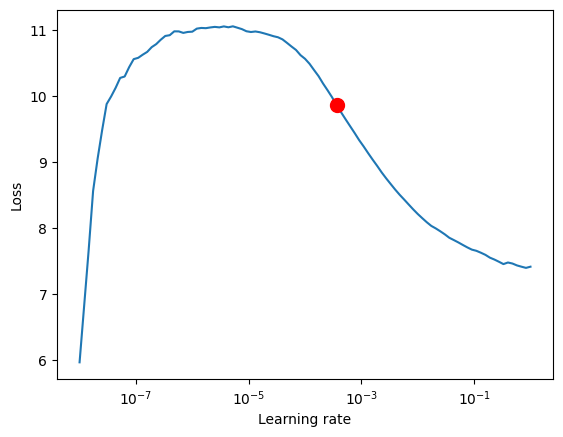

In [57]:
trainer = pl.Trainer()
tuner = Tuner(trainer)
lr_finder = tuner.lr_find(model, train_loader, val_loader)

new_lr = lr_finder.suggestion()
model.hparams.lr = new_lr

fig = lr_finder.plot(suggest=True)
fig.show()

In [58]:
print(new_lr)

0.000363078054770101


In [59]:
epochs = 50
lr = new_lr

model = StanfordCarsNet.load_from_checkpoint(
                                                checkpoint_callback.best_model_path, 
                                                lr=lr, 
                                                weight_decay=weight_decay,
                                                is_finetuned = True)

trainer = pl.Trainer(max_epochs=epochs,
                     accelerator='gpu',
                     default_root_dir = os.path.join(log_dir, "phase2"),
                     callbacks=[metric_tracker, checkpoint_callback, lr_monitor])

trainer.fit(model=model,
            train_dataloaders = train_loader,
            val_dataloaders = val_loader)

INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name              | Type               | Params
---------------------------------------------------------
0 | feature_extractor | Sequential         | 23.5 M
1 | classifier        | Sequential         | 401 K 
2 | train_acc         | MulticlassAccuracy | 0     
3 | val_acc           | MulticlassAccuracy | 0     
4 | test_acc          | MulticlassAccuracy | 0     
---------------------------------------------------------
23.9 M    Trainable params
0         Non-trainable params
23.9 M    Total params
95.639    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=50` reached.


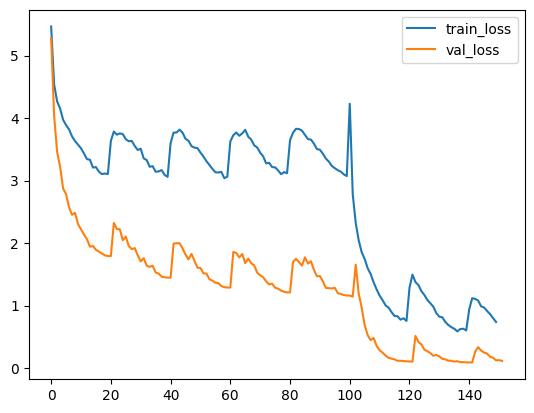

In [60]:
sns.lineplot(x=range(len(metric_tracker.train_loss)), y=metric_tracker.train_loss, label="train_loss")
sns.lineplot(x=range(len(metric_tracker.val_loss)), y=metric_tracker.val_loss, label="val_loss")
plt.legend()
plt.show()

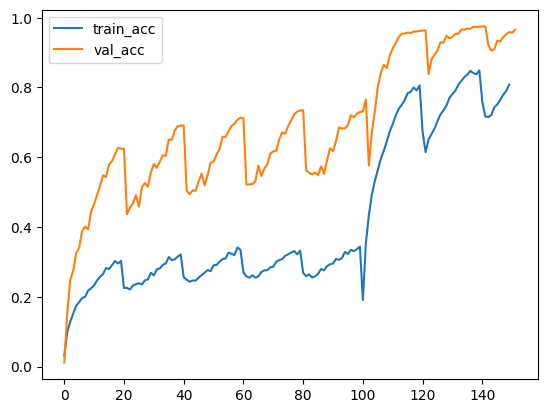

In [61]:
sns.lineplot(x=range(len(metric_tracker.train_acc)), y=metric_tracker.train_acc, label="train_acc")
sns.lineplot(x=range(len(metric_tracker.val_acc)), y=metric_tracker.val_acc, label="val_acc")
plt.legend()
plt.show()

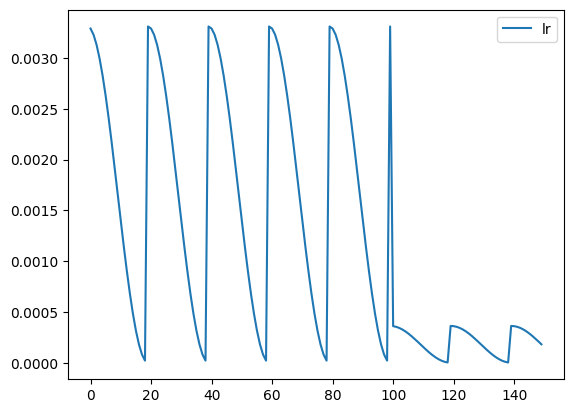

In [62]:
sns.lineplot(x=range(len(metric_tracker.lr)), y=metric_tracker.lr, label="lr")
plt.legend()
plt.show()

In [63]:
trainer.test(model, test_loader)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8486506938934326     │
└───────────────────────────┴───────────────────────────┘

[{'test_acc': 0.8486506938934326}]